# Церцвадзе Амиран

In [ ]:
import os
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torch.utils.data as data
import torchvision.models as models
import torchvision.transforms as transforms

import PIL
from PIL import Image, ImageDraw
from torch.utils.data import DataLoader

import warnings
warnings.filterwarnings('ignore')

import cv2
from torch.utils.data import Dataset
from glob import glob

import matplotlib.pyplot as plt
from matplotlib import patches,  lines
from matplotlib.patches import Polygon
from skimage.measure import find_contours
import colorsys

from collections import Counter

## Часть 1. Копаемся в данных

На этот раз  у нас будет небольшой датасет из гуляющих людей (вы удивитесь насколько небольшой). Данные можно скачать [здесь](https://drive.google.com/file/d/11B511Gi1X60MtW1KVYY5Eq9jP0qQnJmR/view?usp=sharing).

Для того, чтобы учить сеть, нужен будет Dataloader, а значит и собственный Dataset. Чтобы собрать Dataset надо понять как выглядят данные и аннотация, а также какие данные понадобятся вашей сетке для обучения.

**Нужно чтобы данные лежали у вас архивом на Гуглдиске, тогда, поменяв директорию, ваши результаты можно будет воспроизвести и оценить.**

Обратите внимание, что единственная ваша аннотация - маски. Мы хотим учить Mask R-CNN, которой для обучения нужны и боксы для детекции, их надо получить самим.









### **Задание 1** (2 балла)
Разархивируйте данные, загрузите и посмотрите на фото и соответствующие им маски (соответствие происходит явно по имени ), напишите функцию, которая по маске высчитывает бокс, отрисуйте 4-5 фото с масками и боксами, как это было сделано на семинаре. Отсортируйте картинки по имени и разделите на train/test - в соотношении 4:1.

In [ ]:
from google.colab import drive

drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
!unzip -q /content/gdrive/My\ Drive/Colab\ Notebooks/07.\ Mask-RCNN/Pedestrians.zip -d ./

In [ ]:
img_paths = glob(f"./Pedestrians/imgs/*")
img_paths = sorted(img_paths, key= lambda x: int(x.rsplit("/", 1)[-1][:-4]))

idxs = [i.rsplit("/", 1)[-1][:-4] for i in img_paths]
mask_paths = [f"./Pedestrians/masks/{i}.png" for i in idxs]

transform = transforms.ToTensor()

Нарисуем несколько фотографий и соответствующих им масок.

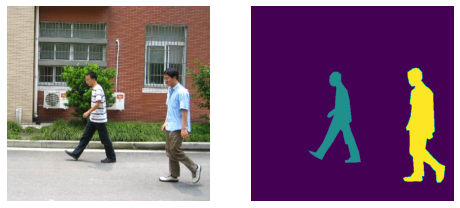

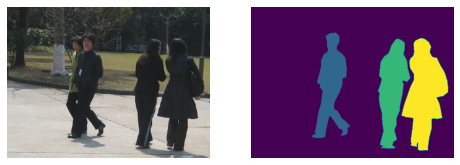

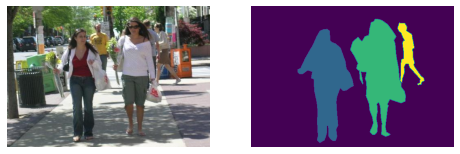

In [ ]:
for i in range(0, 150, 60):
  img = Image.open(img_paths[i]).convert('RGB')
  mask = Image.open(mask_paths[i])
  f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6))
  ax1.imshow(img)
  ax2.imshow(mask)
  ax1.axis("off")
  ax2.axis("off")
  plt.show()

Разделим маски на отдельных людей и найдем боксы.

In [ ]:
def separate_mask(mask):  #разбиваем маски на отдельных людей
  values = np.unique(mask)
  separated_mask = []
  for value in values[1:]:
    one_mask = 1 * (mask[0] == value).numpy()
    separated_mask.append(one_mask)
  return torch.tensor(separated_mask)

In [ ]:
def boxes_from_masks(masks):  # return x1, y1 - left bottom, x2, y2 - right upper
  boxes = []
  for i in range(masks.shape[0]):
    mask = masks[i].numpy()
    horizontal_indicies = np.where(np.any(mask, axis=0))[0]
    vertical_indicies = np.where(np.any(mask, axis=1))[0]
    if horizontal_indicies.shape[0]:
      x1, x2 = horizontal_indicies[[0, -1]]
      y1, y2 = vertical_indicies[[0, -1]]
      x2 += 1
      y2 += 1
    else:
      x1, x2, y1, y2 = 0, 0, 0, 0
    boxes.append([x1, y1, x2, y2])
  return torch.tensor(boxes)


Волшебство с семинара.

In [ ]:
def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors

def apply_mask(image, mask, color, alpha=0.5):
    for c in range(3):
        image[:, :, c] = np.where(mask > 0,
                                  image[:, :, c] * (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image
    
def visualize(image, boxes, masks, scores=None, figsize=(6, 4), ax=None,
                      show_mask=True, show_bbox=True, colors=None):
    """
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    masks: [height, width, num_instances]
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    show_mask, show_bbox: To show masks and bounding boxes or not
    """
    N = boxes.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")
    else:
        assert boxes.shape[0] == masks.shape[0]
    #генерим случайные цвета для разных масок
    if colors == None:
      colors = random_colors(N)
    _, ax = plt.subplots(1, figsize=figsize)
    ax.axis('off')

    masked_image = image.numpy().transpose(1, 2, 0)
    for i in range(N):
        color = colors[i]
        #рисуем бокс
        x1, y1, x2, y2 = boxes[i]
        if show_bbox:
            p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, alpha=0.7,
                                 linestyle="dashed", edgecolor=color, facecolor='none')
            ax.add_patch(p)
        #рисуем маску
        mask = masks[i, :, :]
        if show_mask:
            masked_image = apply_mask(masked_image, mask, color)
    masked_image = np.clip(masked_image, 0, 1)
    ax.imshow(masked_image)
    plt.show()

Отрисуем получившиеся маски и боксы.

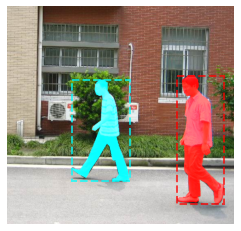

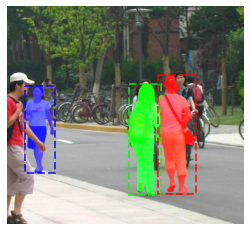

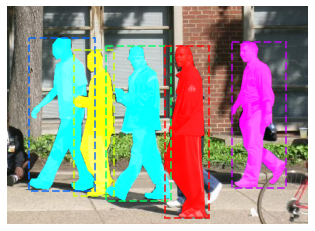

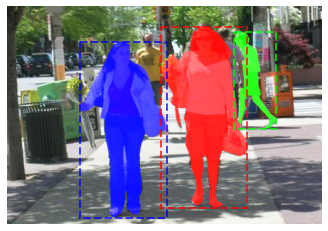

In [ ]:
for ind in range(0, 150, 40):
  img_path = img_paths[ind]
  img = transform(Image.open(img_path).convert('RGB'))
  mask_path = mask_paths[ind]
  mask = transform(Image.open(mask_path))
  masks = separate_mask(mask)
  boxes = boxes_from_masks(masks)
  im = visualize(img, boxes, masks)

Сортировка по имени происходит дальше внутри Dataset. Разбиение на train и test так же осуществляется в следующем задании.

### **Задание 2** (4 балла)

Посмотрите что принимает на вход та Mask R-CNN, которую вы выбрали. Напишите для нее Dataset.

In [ ]:
def collate_fn(batch):    #собирать в батч картинки разных размеров
    return tuple(zip(*batch))

In [ ]:
#Заготовка датасета, можете менять её как удобно, главное чтобы работало

class Pedestrian(Dataset):
    def __init__(self, root, transforms, phase='train'):
        self.root = root
        self.phase = phase
        self.transforms = transforms
        img_paths = glob(f"{root}/imgs/*")
        img_paths = sorted(img_paths, key= lambda x: int(x.rsplit("/", 1)[-1][:-4]))
        if phase == 'train':
          self.img_paths = img_paths[:-30]
        else:
          self.img_paths = img_paths[-30:]

        idxs = [i.rsplit("/", 1)[-1][:-4] for i in self.img_paths]
        mask_paths = [f"{root}/masks/{i}.png" for i in idxs]
        self.mask_paths = mask_paths

    def __getitem__(self, idx):

        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transforms is not None:
          img = self.transforms(img)

  
        mask_path = self.mask_paths[idx]
        mask = Image.open(mask_path)
        if self.transforms is not None:
          mask = self.transforms(mask)
          
        masks = separate_mask(mask)
        boxes = boxes_from_masks(masks)
        #хоть лейбл один, он всё же нужен для обучения (для каждого инстанса нужна 1)
        labels = torch.ones(masks.shape[0], dtype=torch.int64)

        targets = {}
        targets["boxes"] = boxes
        targets["labels"] = labels
        targets["masks"] = masks
        targets["image_id"] = torch.tensor(int(img_path[-7:-4]))

        return img, targets

    def __len__(self):
        return len(self.img_paths)

In [ ]:
transform = transforms.ToTensor()
train_dataset = Pedestrian("./Pedestrians", transforms=transform, phase='train')
test_dataset = Pedestrian("./Pedestrians", transforms=transform, phase='test')

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=False, num_workers=4, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4, collate_fn=collate_fn)

## Часть 2. Копаемся в Mask R-CNN

Это самая свободная в реализации часть - модифицируем и учим Mask R-CNN.

### **Задание 3**. (2 балла) 

Нужно взять Mask R-CNN и заменить у нее последний слои (помните, у нас всего 1 класс?)

### **Задание 4**. (12 баллов) 

1. Подотовьте код для обучения и тестирования. **Явно пропишите свои функции train, evaluate.**

Процедуры обучения и эвала можно посмотреть тут: [тык 1](https://github.com/pytorch/vision/blob/master/references/detection/engine.py), [тык 2](https://github.com/multimodallearning/pytorch-mask-rcnn/blob/master/model.py#L1736), [тык 3](https://github.com/pytorch/vision/blob/0467c9d74c9b34f91df905ed8cf8433de48d7fa5/references/detection/coco_eval.py#L19). Во многих репозиториях вы увидите, что процедуры написаны специально для [coco](https://cocodataset.org/#home) - это потому что это самый популярный датасет для детектирования и сегментации. 

2. Постарайтесь выйти на хорошее качество на test - **bbox AP@IoU=0.75 >=0.95**. И напишите в комментариях какими источниками пользовались.

3. Получите также результат детекции/сегментации для класса 1 (person) у первоначальной сети (не измененной и доученной вами) на том же pedestrians test сете. Получилось ли у вас улучшить показатели для этой задачи по сравнению с базовой моделью? 

Ещё раз почитать про AP [тут](https://medium.com/@jonathan_hui/map-mean-average-precision-for-object-detection-45c121a31173) или на русском то же самое [тут](https://ml.i-neti.com/ru/2019/07/05/russkiy-map-mean-average-precision-v-detektsii-obektov/).

Да, нужно будет много покопаться в коде, но **вы справитесь**.


### Много кода

In [ ]:
def train_epoch(model, optimizer, data_loader, device, epoch):
    print('Epoch:', epoch + 1,'/', num_epoch)
    model.train()
    running_loss = 0
    for i , data in enumerate(data_loader):
        images, targets = data
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        running_loss += losses.item()

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    print('Train loss:', running_loss / (i + 1))

In [ ]:
def evaluate(model, data_loader, device, iou_threshold=0.75):
    
    model.eval()
    pred = []
    targ = []
    for i, data in enumerate(data_loader):
        images, targets = data
        images = list(image.to(device) for image in images)
        targ.extend(targets)

        prediction = model(images)
        for i, p in enumerate(prediction):
          p['image_id'] = targets[i]['image_id']

        pred.extend(prediction)
    
    prediction_raveled = ravel_target(pred, True)
    target_raveled = ravel_target(targ)

    ap = ap_recall_precision(target_raveled, prediction_raveled, iou_threshold)
    print('Test AP@{}: {}'.format(iou_threshold, ap))
    return targ, pred 

In [ ]:
# Блок для вычисления AP

# разворачивает список словарей, отсекает нужный класс
def ravel_target(target, prediction=False):
  res = []
  for t in target:
    for i in range(t['labels'].shape[0]):
      if t['labels'][i] == 1:
        d = {}
        d['boxes'] = t['boxes'][i].cpu()
        d['labels'] = t['labels'][i].cpu()
        d['image_id'] = t['image_id'].cpu()
        #d['masks'] = t['masks'][i]
        if prediction:
          d['scores'] = t['scores'][i].cpu()
        res.append(d)
  return res

# AP from recall and precision
def AveragePrecision(recall, precision):
        mrec = []
        mrec.append(0)
        [mrec.append(e) for e in recall]
        mrec.append(1)
        mpre = []
        mpre.append(0)
        [mpre.append(e) for e in precision]
        mpre.append(0)
        for i in range(len(mpre) - 1, 0, -1):
            mpre[i - 1] = max(mpre[i - 1], mpre[i])
        ii = []
        for i in range(len(mrec) - 1):
            if mrec[1:][i] != mrec[0:-1][i]:
                ii.append(i + 1)
        ap = 0
        for i in ii:
            ap = ap + np.sum((mrec[i] - mrec[i - 1]) * mpre[i])
        return ap

# IOU
def getIOUs(gt_boxes, box):
    i_xmin = np.maximum(gt_boxes[:, 0], box[0])
    i_ymin = np.maximum(gt_boxes[:, 1], box[1])

    i_xmax = np.minimum(gt_boxes[:, 2], box[2])
    i_ymax = np.minimum(gt_boxes[:, 3], box[3])

    iw = np.maximum(i_xmax - i_xmin, 0.0)
    ih = np.maximum(i_ymax - i_ymin, 0.0)

    intersection = iw * ih
    union = (box[2] - box[0]) * (box[3] - box[1]) + (gt_boxes[:, 2] - gt_boxes[:, 0]) * (gt_boxes[:, 3] - gt_boxes[:, 1]) - intersection

    ious = intersection / (union + 1e-7)

    return ious

# по развернутым словарям выдает AP, recall, precision
def ap_recall_precision(target, pred, iou_threshold, rp=False):   
            # sort detections by decreasing scores
            pred = sorted(pred, key=lambda x: x['scores'], reverse=True)
            TP = np.zeros(len(pred))
            FP = np.zeros(len(pred))
            # create dictionary with amount of gts for each image
            det = Counter([t['image_id'] for t in target])
            for key, val in det.items():
                det[key] = np.zeros(val)
            # Loop through pred
            for d in range(len(pred)):
                # Find ground truth boxes for the same image
                targ_boxes = np.array([t['boxes'].numpy() for t in target if t['image_id'] == pred[d]['image_id']])
                ious = getIOUs(targ_boxes, pred[d]['boxes'].numpy())
                iou_max = np.max(ious)
                jmax = np.argmax(ious)
                # Assign detection as true positive/false positive
                if iou_max >= iou_threshold:
                    if det[pred[d]['image_id']][jmax] == 0:
                        TP[d] = 1  
                        det[pred[d]['image_id']][jmax] = 1  # flag as already 'seen'
                    else:
                        FP[d] = 1  
                else:
                    FP[d] = 1 
            # compute precision, recall
            acc_FP = np.cumsum(FP)
            acc_TP = np.cumsum(TP)
            recall = acc_TP / len(target)
            precision = np.divide(acc_TP, (acc_FP + acc_TP))
            ap = AveragePrecision(recall, precision)
            if rp:
              return ap, recall, precision
            else:
              return ap

In [ ]:
# отсечение масок и объектов
def get_prediction(img, threshold_mask, threshold_obj, transform):
  output = model([transform(img).cuda()])[0]
  flag = output["scores"] >= threshold_obj
  pred_boxes = output["boxes"][flag].cpu()
  pred_class = output["labels"][flag].cpu()
  _pred_masks = output["masks"][flag].cpu()
  pred_masks = _pred_masks >= threshold_mask
  return pred_masks, pred_boxes, pred_class

### Результат детекции с замененным последним слоем

In [ ]:
from torchvision.models.detection import maskrcnn_resnet50_fpn as mask_rcnn

In [ ]:
torch.cuda.is_available()

True

In [ ]:
model = mask_rcnn(pretrained=True)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


In [ ]:
for parameter in model.parameters(): 
    parameter.requires_grad = False

In [ ]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

num_classes = 2  #background + person 
in_features = 1024
in_features_mask = 256
hidden_layer = 256

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

Сначала обучаем только замененные слои.

In [ ]:
device = torch.device('cuda')
model = model.cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epoch = 3
iou_threshold = 0.75

In [ ]:
for i in range(num_epoch):
  train_epoch(model, optimizer, train_loader, device, i)
  with torch.no_grad():
    target, prediction = evaluate(model, test_loader, device)
  print('----------------------')
print('Finished!')

Epoch: 1 / 3
Train loss: 1.0885683794816334
Test AP@0.75: 0.9410435646001125
----------------------
Epoch: 2 / 3
Train loss: 0.4476458882292112
Test AP@0.75: 0.9815776624562159
----------------------
Epoch: 3 / 3
Train loss: 0.3386730740467707
Test AP@0.75: 0.994269900802963
----------------------
Finished!


Теперь всю сетку.

In [ ]:
for parameter in model.parameters(): 
    parameter.requires_grad = True
num_epoch = 5
optimizer = optim.Adam(model.parameters(), lr=1e-5)

In [ ]:
for i in range(num_epoch):
  train_epoch(model, optimizer, train_loader, device, i)
  with torch.no_grad():
    target, prediction = evaluate(model, test_loader, device)
  print('----------------------')
print('Finished!')

Epoch: 1 / 5
Train loss: 0.28110716342926023
Test AP@0.75: 0.9973783694937544
----------------------
Epoch: 2 / 5
Train loss: 0.22422739068667094
Test AP@0.75: 0.9815281940281939
----------------------
Epoch: 3 / 5
Train loss: 0.1977516715725263
Test AP@0.75: 0.9797851582170127
----------------------
Epoch: 4 / 5
Train loss: 0.1843337632715702
Test AP@0.75: 0.9976923076923074
----------------------
Epoch: 5 / 5
Train loss: 0.17365982631842294
Test AP@0.75: 0.9976923076923074
----------------------
Finished!


Качество высокое, посмотрим на recall precision curve.

In [ ]:
def draw_recall_precision(r, p):
  mrec = []
  mrec.append(0)
  [mrec.append(e) for e in r]
  mrec.append(1)
  mpre = []
  mpre.append(0)
  [mpre.append(e) for e in p]
  mpre.append(0)
  for i in range(len(mpre) - 1, 0, -1):
      mpre[i - 1] = max(mpre[i - 1], mpre[i])
  plt.figsize=(8, 6)
  plt.plot(mrec, mpre, color='m')
  plt.title('Smoothed recall precision curve')
  plt.xlabel('recall')
  plt.ylabel('precision')
  plt.grid()

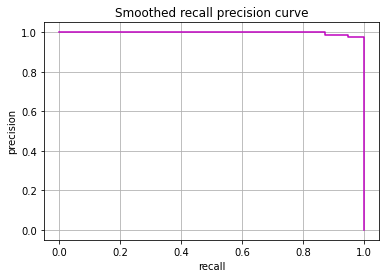

In [ ]:
prediction_raveled = ravel_target(prediction, True)
target_raveled = ravel_target(target)
ap, r, p = ap_recall_precision(target_raveled, prediction_raveled, 0.75, rp=True)
draw_recall_precision(r, p)

Посмотрим на картинки.

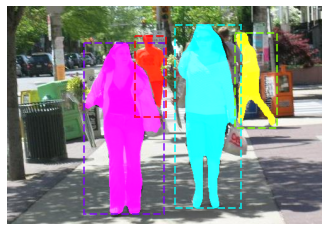

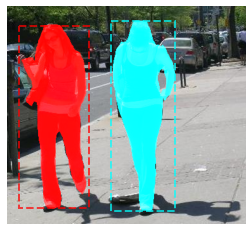

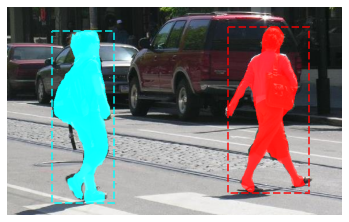

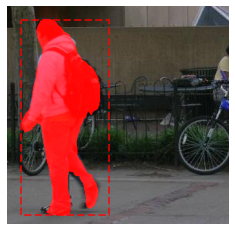

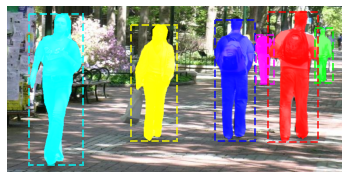

In [ ]:
for i in range(0, 30, 6):
  img = Image.open(img_paths[prediction[i]['image_id'].item()]).convert('RGB')
  masks, boxes, classes = get_prediction(img, 0.5,  0.6, transform)
  visualize(transform(img), boxes, masks)

На 3 и 4 картинке видны изъяны, но в целом хорошо.

### Результат детекции для первоначальной сети

Посчитаем скор для неизменной и недообученной сети:

In [ ]:
model = mask_rcnn(pretrained=True)
model = model.cuda()
iou_threshold = 0.75

In [ ]:
with torch.no_grad():
  target, prediction = evaluate(model, test_loader, device)

Test AP@0.75: 0.9694738430315368


Совсем чуть-чуть похуже. Посмотрим на AP, если дообучить сеть:

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-5)
num_epoch = 4

In [ ]:
for i in range(num_epoch):
  train_epoch(model, optimizer, train_loader, device, i)
  with torch.no_grad():
    target, prediction = evaluate(model, test_loader, device, iou_threshold)
  print('----------------------')
print('Finished!')

Epoch: 1 / 4
Train loss: 0.2719809835155805
Test AP@0.75: 0.9965695846429032
----------------------
Epoch: 2 / 4
Train loss: 0.20779804587364198
Test AP@0.75: 0.9978638805531989
----------------------
Epoch: 3 / 4
Train loss: 0.18607754757006964
Test AP@0.75: 0.9972322339620159
----------------------
Epoch: 4 / 4
Train loss: 0.16968746930360795
Test AP@0.75: 0.9968948520456866
----------------------
Finished!


Снова хорошо. Результат такой же (0.997 vs 0.996), как с заменой слоя. 

### Что использовалось

для Average Precision:
https://github.com/rafaelpadilla/Object-Detection-Metrics/blob/5219f40c7d15c444f0e72a569d8f0b5cdf311bd0/lib/Evaluator.py#L292

для train/evaluate:
https://github.com/pytorch/vision/blob/master/references/detection/engine.py

прошлые семинары по Unet и MaskRCNN для визуализации, создания датасета

## Часть 3. Копаемся с видео (это бонусная часть!)

Давайте теперь сделаем классный видос, чтобы все видели какие мы молодцы. 
Видео для теста живет тут: https://www.epfl.ch/labs/cvlab/data/data-pom-index-php/

Берем оттуда **Campus sequences - [Seq.1, cam. 1].**

### **Задание 5**. (6 баллов)

Пишем Dataset для видео. Впервые он будет иметь метод не get_item, а iter, так как по видео мы хотим пройти один раз и фрейм за фреймом отправлять в сетку, смотрите доки по IterableDataset [тут](https://pytorch.org/docs/stable/data.html#torch.utils.data.IterableDataset). Можно использовать и обычный Dataset, но для get_item нам надо уметь выдергивать из видео фрейм по конкретному индексу, а для VideoCapture этот метод работает плохо (возможны неточные выдергивания и ваши визуализации полетят к чертям).

Так как это eval процедура, можете вообще не использовать Dataset и Dataloader, а читать последовательно кадры и оборачивать их в тензоры для сети. 

Далее прогоняем картинки через сетку и для кадров собираем результаты по маскам и детекциям (используйте в лоадере batch_size=1, num_workers=0 - иначе с VideoCapture могут возникнуть проблемы)

Пробегаем по видео ещё раз, рисуем на фреймах маски и боксы как и в 1 задании (цвет выберите один раз для всех масок чтобы каждый кадр он не мигал), собираем всё в видео - наслаждаемся. Видео сдайте вместе с заданием.


In [ ]:
from cv2 import VideoWriter, VideoWriter_fourcc

In [ ]:
def draw_masks(img, masks, colors=None):
  masked_image = img
  color = (0.8, 0.0, 0.0)
  for i in range(masks.shape[0]):
    if colors != None:
      color = colors[i]
    mask = masks[i, :, :]
    masked_image = apply_mask(img, mask, color)
  return masked_image

def draw_boxes(img, boxes, colors=None):
  color = (220, 0, 0)
  img = Image.fromarray(img)
  draw = ImageDraw.Draw(img)
  for i in range(boxes.shape[0]):
    if colors != None:
      color = colors[i]
      color = tuple([int(c * 255) for c in color])
    draw.rectangle(boxes[i].tolist(), outline=color, width=1)
  return np.array(img)

In [ ]:
model.eval()          #тут была первая замененная моделька

In [ ]:
video = cv2.VideoCapture('campus4-c1.avi')
fps_ = video.get(cv2.CAP_PROP_FPS)

format = "FMP4"
fps=fps_
is_color=True
fourcc = VideoWriter_fourcc(*format)
size = 360, 288
path = 'pedestrians.mp4'
vid = VideoWriter(path, fourcc, float(fps), size, is_color)

Тут все очень просто: считываем очередной фрейм, получаем для него предсказание, рисуем маски и боксы, добавляем размеченный фрейм в новое видео.

In [ ]:
while True:
  status, img = video.read()
  if not status:
            break
  masks, boxes, classes = get_prediction(img, 0.4,  0.35, transform)
  masked_image = draw_masks(img, masks)
  masked_image = draw_boxes(masked_image, boxes)
  vid.write(masked_image)
  
vid.release()
video.release()

### **Задание 6**. (4 балла)

Вспоминаем, что вообще то мы делали instance segmentaion и знаем, что у нас ходят отдельные люди - сделайте простенький трекинг с матчингом боксов с соседних фреймов по IoU детекций.

Идея проста - если на фреймах N и N+1 IoU двух боксов > threshold, то считаем что трек остался тот же - и для него сохраняем цвет визуализации бокса с фрейма N, если нет - заводим новый цвет. И учитываем что бокс может сматчиться только с ОДНИМ боксом с предыдущего кадра. Что за IoU ещё раз смотрим [тут](https://medium.com/towards-artificial-intelligence/understanding-iou-metric-in-object-detection-1e5532f06a76).

Для тех же боксов и масок нарисуйте ещё одно видео - где каждый человек будет иметь **один** цвет **от начала до конца** своего присутствия в видео (фактически трекаться). 

Этот прекрасный видос тоже прикладывайте к заданию, я обязательно посмотрю.

In [ ]:
def update_colors(boxes, prev_boxes, prev_colors, threshold=0.62):
  colors = []
  for i, box in enumerate(boxes):
    if not prev_boxes.shape[0]:
      c = all_colors[i]
    else:
      ious = getIOUs(prev_boxes.numpy(), box.numpy())
      iou_max = np.max(ious)
      j_max = np.argmax(ious)
      if (iou_max >= threshold) and (prev_colors[j_max] not in colors): #2ое усл помогает трекать расход-ся
        c = prev_colors[j_max]                                          #людей разными цветами
      else:
        for c_ in all_colors:
          if (c_ not in colors) and (c_ not in prev_colors):
            c = c_
            break
    colors.append(c)
  return colors

In [ ]:
all_colors = random_colors(10)

In [ ]:
video = cv2.VideoCapture('campus4-c1.avi')

path = 'pedestrians_colors.mp4'
vid = VideoWriter(path, fourcc, float(fps), size, is_color)

In [ ]:
with torch.no_grad():
  first = True
  while True:
    status, img = video.read()
    if not status:
              break
    masks, boxes, classes = get_prediction(img, 0.4,  0.45, transform)
    if first:
      colors = random_colors(boxes.shape[0])
      first = False
    else:
      colors = update_colors(boxes, prev_boxes, prev_colors)
    masked_image = draw_masks(img, masks, colors)
    masked_image = draw_boxes(masked_image, boxes, colors)
    vid.write(masked_image)
    prev_boxes = boxes
    prev_colors = colors
  vid.release()
  video.release()

## **А вот и конец дз. Вы просто великолепны!**